Kalkulatory IEEE-754:
* https://www.h-schmidt.net/FloatConverter/IEEE754.html

In [1]:
# znak, cecha, mantysa
# uwaga - w Julii tablice indeksujemy od 1
# uwaga: ukryta jedynka nie jest pamiętana
# uwaga: cecha jest pamiętana w kodzie z nadmiarem (tutaj BIAS=127)
decode(x::Float32) = (b=bitstring(x); (b[1], b[2:9], b[10:32]))

decode (generic function with 1 method)

## Trochę teorii o IEEE-754

Liczby zmienno przecinkowe są zapisywane w standardzie jako:

$L = (-1)^{znak} * mantysa * 2^{cecha}$ 

* znak - 0 oznacza liczbę dodatnią, 1 ujemną
* mantysa - wpływa na precyzje
* cecha - wpływa na zakres, składająca się z samych 0 albo 1 ma specjalne znaczenie

| Nazwa     | Liczba bitów | Bity znaku | Bity cechy | Bity mantysy | Bias  | Dokładność (cyfry znaczące) | Uwagi                                 |
|-----------|--------------|------------|------------|--------------|-------|-----------------------------|---------------------------------------|
| half      | 16           | 1          | 5          | 10           | 15    | 4                           |                                       |
| single    | 32           | 1          | 8          | 23           | 127   | 7                           |                                       |
| double    | 64           | 1          | 11         | 52           | 1023  | 16                          |                                       |
| quadruple | 128          | 1          | 15         | 112          | 16383 | 34                          | Wprowadzone w 2008, niezbyt popularne |

### Liczby znormalizowane

Mantysa ma wartość z przedziału [1,2) - pierwszy bit ma zawsze wartość 1, więc nie trzeba go zapisywać (jest on tam "domyślnie")
$L = (-1)^{znak} * 1.mantysa * 2^{cecha-bias}$

In [2]:
decode(Float32(2.5))

('0', "10000000", "01000000000000000000000")

Policzenie wartości na podstawie reprezentacji bitowej.

In [3]:
cecha = 2^7-127
mantysa = 2^-2 + 1
cecha, mantysa

(1, 1.25)

In [4]:
L = 1 * mantysa * 2^cecha

2.5

### Liczba 0

Wartości 0 nie da się zapisać w postaci znormalizowanej. Jeżeli zarówno mantysa jak i cecha zawierają same 0, to reprezentowana jest wartość 0.

Ze względu na bit znaku, istnieją dwie możliwości 0: +0 oraz -0.

In [5]:
decode(Float32(-0.0))

('1', "00000000", "00000000000000000000000")

In [6]:
decode(Float32(+0.0))

('0', "00000000", "00000000000000000000000")

In [7]:
Float32(-0.0) == Float32(+0.0) # Oba zera są równe

true

### Liczby zdenormalizowane

Jeżeli cecha składa się z samych 0 to liczba jest *zdenormalizowana* i mantysa nie posiada "domyślnego" bitu. Pozwala to na reprezentacje liczb bliskich 0, które bez denormalizacji byłyby 0.

$L = (-1)^{znak} * 0.mantysa * 2^{-bias+1}$

Uwaga: Liczba 0 nie jest określana jako zdenormalizowana, pomimo, że cecha ma same 0!

In [9]:
L = Float32(1e-42)
decode(Float32(L)), issubnormal(L)

(('0', "00000000", "00000000000001011001010"), true)

### Wartości specjalne

####  Nieskończoność

Reprezentowana jest przez cechę z samych 1 oraz mantysę z samych 0. W zależności od znaku można wyróżnić $-\infty$ oraz $+\infty$.

In [10]:
decode(Inf32)

('0', "11111111", "00000000000000000000000")

In [11]:
decode(-Inf32)

('1', "11111111", "00000000000000000000000")

#### NaN

Reprezentowana jest przez cechę z samych 1 oraz mantysę różną od 0.

`NaN`ami są np. 0/0, $\infty - \infty$

In [12]:
Float32(0)/Float32(0)

NaN32

In [13]:
Inf32 - Inf32

NaN32

In [14]:
decode(NaN32)

('0', "11111111", "10000000000000000000000")

### Praktyczne wskazówki

Kolejność działań ma znaczenie:

In [15]:
e = eps(Float32)/2

5.9604645f-8

In [16]:
(Float32(1.0) + e) + e

1.0f0

In [17]:
Float32(1.0) + (e + e)

1.0000001f0

Wniosek: Sumujemy od najmniejszych

Nie powinno się porównywać floatów bezpośrednio. Większość języków posiada funkcje do porówywania liczb zmiennoprzecinkowych z tolerancją, np. `isapprox` w Julii, `numpy.isclose` w Pythonie etc.

In [18]:
0.1 + 0.2 == 0.3

false

In [19]:
isapprox(0.1 + 0.2, 0.3)

true

## Przykłady

In [20]:
bitstring(Float32(.1))

"00111101110011001100110011001101"

In [21]:
bitstring(Float32(1.0))

"00111111100000000000000000000000"

In [22]:
bitstring(Float64(1.0))

"0011111111110000000000000000000000000000000000000000000000000000"

In [23]:
# domyślnie Float64
bitstring(1.0)

"0011111111110000000000000000000000000000000000000000000000000000"

In [24]:
# Float16
bitstring(Float16(1.0))

"0011110000000000"

In [25]:
println(significand(Float32(1.2)), "*2^", exponent(Float32(1.20)))

1.2*2^0


In [26]:
# co ile liczby sa reprezentowane 
c=Float32[]
a=Float32(1.0)
r=1:10
for i=r
    push!(c, a)
    a=nextfloat(a)
end
map(x-> bitstring(x),c)

10-element Vector{String}:
 "00111111100000000000000000000000"
 "00111111100000000000000000000001"
 "00111111100000000000000000000010"
 "00111111100000000000000000000011"
 "00111111100000000000000000000100"
 "00111111100000000000000000000101"
 "00111111100000000000000000000110"
 "00111111100000000000000000000111"
 "00111111100000000000000000001000"
 "00111111100000000000000000001001"

In [27]:
# Maszynowe epsilon mówi, jaki jest odstęp między kolejnymi liczbami zmiennoprzecinkowymi reprezentowanymi w komputerze
eps(Float32(1))

1.1920929f-7

In [28]:
eps(Float32(2))

2.3841858f-7

In [29]:
# Badanie postaci zdenormalizowanej. Co się dzieje, jak liczby są coraz mniejsze?
a = Float32(1e-33)
while a > 0
    a = a/Float32(2.0)
    println(a, decode(a),  " ", issubnormal(a))
end

5.0e-34('0', "00010000", "01001100010011101001100") false
2.5e-34('0', "00001111", "01001100010011101001100") false
1.25e-34('0', "00001110", "01001100010011101001100") false
6.25e-35('0', "00001101", "01001100010011101001100") false
3.125e-35('0', "00001100", "01001100010011101001100") false
1.5625e-35('0', "00001011", "01001100010011101001100") false
7.8125e-36('0', "00001010", "01001100010011101001100") false
3.90625e-36('0', "00001001", "01001100010011101001100") false
1.953125e-36('0', "00001000", "01001100010011101001100") false
9.765625e-37('0', "00000111", "01001100010011101001100") false
4.8828126e-37('0', "00000110", "01001100010011101001100") false
2.4414063e-37('0', "00000101", "01001100010011101001100") false
1.2207032e-37('0', "00000100", "01001100010011101001100") false
6.103516e-38('0', "00000011", "01001100010011101001100") false
3.051758e-38('0', "00000010", "01001100010011101001100") false
1.525879e-38('0', "00000001", "01001100010011101001100") false
7.629395e-39('0

In [30]:
# Rysowanie wykresów
#using Pkg
#Pkg.add("Plots")
# http://docs.juliaplots.org/latest/tutorial/
using Plots

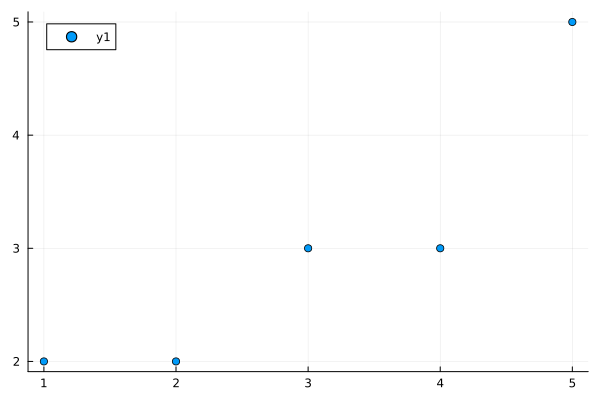

In [31]:
scatter(1:1:5, [2,2,3,3,5])

## Bonus

Ciekawe zastosowanie znajomości IEEE-754 do obliczania odwrotności pierwiastka, wykorzystane w grze Quake 3: [filmik](https://youtu.be/p8u_k2LIZyo)

# Zadania

### Zadanie 1

Porównać w języku Julia reprezentację bitową liczby 1/3 dla `Float16`, `Float32`, `Float64` oraz liczby, 
która jest inicjalizowana jako `Float16`, a potem rzutowana na `Float64`.

In [32]:
function bit_representation()
    vals = [Float16(1/3), Float32(1/3), Float64(1/3), Float64(Float16(1/3))]
    types = ["Float16", "Float32", "Float64", "Float16 -> Float64"]
    for (t, v) in zip(types, vals)
        println("$t: ", bitstring(v))
    end
end

bit_representation()

Float16: 0011111111010101010101000000000000000000000000000000000000000000
Float32: 0011111111010101010101010101010101100000000000000000000000000000
Float64: 0011111111010101010101010101010101010101010101010101010101010101
Float16 -> Float64: 0011111111010101010101000000000000000000000000000000000000000000


### Zadanie 2

Zbadać, jak zmienia się odległość między kolejnymi liczbami zminnoprzecinkowymi 
reprezentowanymi w komputerze za pomocą języka Julia. 
Narysować wykres używając Plots zależności odległości od wartości liczby dla zakresu  od 1.0 do 1000000.0.

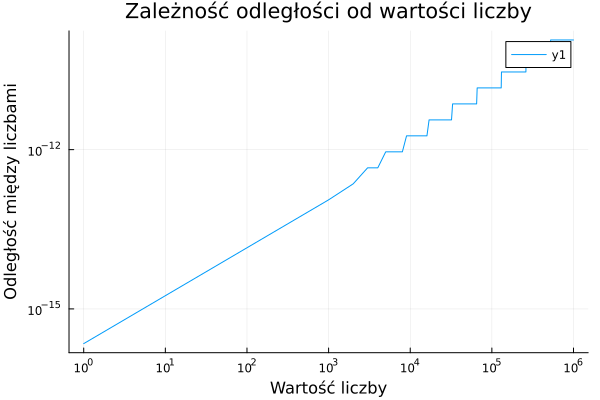

In [33]:
function floating_point_spacing()
    x = range(1.0, stop=1e6, length=1000)
    y = [eps(v) for v in x]
    plot(x, y, xscale=:log10, yscale=:log10, xlabel="Wartość liczby", ylabel="Odległość między liczbami", title="Zależność odległości od wartości liczby")
end

floating_point_spacing()

### Zadanie 3

Jedną z bibliotek numerycznych, jaką dodatkowo będziemy używać na zajęciach jest <a href="http://www.gnu.org/software/gsl/gsl.html">GSL</a> (język C). Opis <a href="https://www.gnu.org/software/gsl/doc/html/usage.html"> jak używać </a>. Korzystając ze <a href="https://www.gnu.org/software/gsl/doc/html/ieee754.html"> wsparcia dla wyświetlania reprezentacji liczb zmiennoprzecinkowych</a> zobaczyć jak zmienia się cecha i mantysa dla coraz mniejszych liczb. Zaobserwować, kiedy matysa przestaje być znormalizowana i dlaczego?

Kod załączyć jako komórka Markdown sformatowana jako C ([link](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#code)). Wynik także jako Markdown (kod albo fragment zrzutu ekranu).

In [ ]:
# ```c
# #include <stdio.h>
# #include <stdint.h>
# 
# void print_float_bits(float x) {
#     union { float f; uint32_t i; } u;
#     u.f = x;
#     for (int i = 31; i >= 0; i--) {
#         printf("%d", (u.i >> i) & 1);
#         if (i == 31 || i == 23) printf(" ");
#     }
#     printf("\n");
# }
# 
# int main() {
#     float x = 1.0;
#     for (int i = 0; i < 30; i++) {
#         print_float_bits(x);
#         x /= 2;
#     }
#     return 0;
# }
# ```

In [ ]:
filipmalejki@MacBook-Pro-Filip lab2 % gcc 3.c -o 3
filipmalejki@MacBook-Pro-Filip lab2 % ./3
0 01111111 00000000000000000000000
0 01111110 00000000000000000000000
0 01111101 00000000000000000000000
0 01111100 00000000000000000000000
0 01111011 00000000000000000000000
0 01111010 00000000000000000000000
0 01111001 00000000000000000000000
0 01111000 00000000000000000000000
0 01110111 00000000000000000000000
0 01110110 00000000000000000000000
0 01110101 00000000000000000000000
0 01110100 00000000000000000000000
0 01110011 00000000000000000000000
0 01110010 00000000000000000000000
0 01110001 00000000000000000000000
0 01110000 00000000000000000000000
0 01101111 00000000000000000000000
0 01101110 00000000000000000000000
0 01101101 00000000000000000000000
0 01101100 00000000000000000000000
0 01101011 00000000000000000000000
0 01101010 00000000000000000000000
0 01101001 00000000000000000000000
0 01101000 00000000000000000000000
0 01100111 00000000000000000000000
0 01100110 00000000000000000000000
0 01100101 00000000000000000000000
0 01100100 00000000000000000000000
0 01100011 00000000000000000000000
0 01100010 00000000000000000000000

### Zadanie 4

Na przykładzie wybranego algorytmu niestabilnego numerycznie: 
1. Pokazać, że działa źle.
2. Pokazać które konkretnie działania powodują zwiększenie błędu (np. dzielenie przez małą liczbę, cancellation).
3. Zademonstować wersję stabilną.

Wszystkie punkty przedstawić w postaci notatnika Julii.

In [50]:
using LinearAlgebra

A = [1.0 1.0 1.0; 1.0 1.0 1.0e-5; 1.0 1.0 1.0]
b = [3.0; 3.0; 3.0]

#metoda eliminacji gaussa
function gauss_elimination(A, b)
    n = length(b)
    for i in 1:n
        #dzielenie
        A[i, :] /= A[i, i]  
        b[i] /= A[i, i]
        
        for j in i+1:n
            factor = A[j, i]
            A[j, :] -= factor * A[i, :]
            b[j] -= factor * b[i]
        end
    end
    return b
end

x = gauss_elimination(A, b)
println("Rozwiązanie układu równań: ", x)

Rozwiązanie układu równań: [3.0, NaN, NaN]


In [48]:
A[2, 2] = 1.0e-10  # zmniejszenie wartości w macierzy A spowoduje zwiększenie błędu (dzielenie przez mała liczbe)

x = gauss_elimination(A, b)
println("Nowe rozwiązanie układu równań: ", x)

Nowe rozwiązanie układu równań: [3.0, NaN, NaN]


In [49]:
using LinearAlgebra

function gauss_elimination_stable(A, b)
    n = length(b)
    
    epsilon = 1e-10
    
    for i in 1:n
        # pivot (max w kolumnie)
        pivot_row = argmax(abs.(A[i:n, i])) + i - 1
        A[[i, pivot_row], :] .= A[[pivot_row, i], :]
        b[i], b[pivot_row] = b[pivot_row], b[i]
        
        # jesli mniejsze od eps to korekta
        if abs(A[i, i]) < epsilon
            A[i, i] += epsilon  # Dodajemy minimalną wartość
        end
        
        # el
        for j in i+1:n
            factor = A[j, i] / A[i, i]
            A[j, :] -= factor * A[i, :]
            b[j] -= factor * b[i]
        end
    end
    
    # rozwiazanie (podstawienie wsteczne)
    x = zeros(n)
    for i in n:-1:1
        x[i] = (b[i] - sum(A[i, i+1:end] .* x[i+1:end])) / A[i, i]
    end
    return x
end

A = [1.0 1.0 1.0; 1.0 1.0 1.0e-10; 1.0 1.0 1.0]
b = [3.0; 3.0; 3.0]

x_stable = gauss_elimination_stable(A, b)
println("Stabilne rozwiązanie układu równań: ", x_stable)


Stabilne rozwiązanie układu równań: [3.0, 0.0, 0.0]
